In [7]:
import os
import sys
import numpy as np
import itertools
import matplotlib.pyplot as plt
from math import pi
import orbithunter as orb
import inspect
import orbithunter.ks as ks
import h5py
import time
from matplotlib import gridspec
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox, widgets

# Investigation into spacetime coverings

In [8]:
def coordinate_mapping_canvas(window, coord_map, sliced=False):
    window_shape = window.shape
    background = np.full([4*x for x in window_shape], np.inf)
    tp, xp = [backdim//2+coord for backdim, coord in zip(background.shape,
                                                 coord_map(np.indices(window_shape), window=False))]
    t, x = coord_map(np.indices(window_shape), window=True)
    background[tp, xp] = window[t,x].ravel()
    if sliced:
        slicer = (slice(np.where(background!=np.inf)[0].min(), np.where(background!=np.inf)[0].max()), 
                  slice(np.where(background!=np.inf)[1].min(), np.where(background!=np.inf)[1].max()))
        background = background[slicer]
    return background

In [9]:
invert=True
def interactwrapper(orbit_cover_instance, trimmed_scores=None, mapped_scores=None, **kwargs):
    mindex = kwargs.get('mindex', 0)
    maxdex = kwargs.get('maxdex', len(orbit_cover_instance.windows)-1)
    windows = orbit_cover_instance.windows
    if trimmed_scores is None:
        trimmed_scores = orbit_cover_instance.trim()
    if mapped_scores is None:
        mapped_scores = orbit_cover_instance.map()
    coord_map = orbit_cover_instance.coordinate_map

    def update(orbit_index):
        nonlocal trimmed_scores
        nonlocal mapped_scores
        nonlocal windows
        nonlocal coord_map
        scores = trimmed_scores[orbit_index]
        vmin = scores.min()
        if scores[scores!=np.inf].size != 0:
            vmax = scores[scores!=np.inf].max()
        else:
            vmax = vmin
        fig = plt.figure(figsize=(20,20)) 


        
        window = windows[orbit_index].state
        window_shape = window.shape
        if coord_map is not None:
            gs = gridspec.GridSpec(6, 4, width_ratios=[10, 10, 10, 3], height_ratios=[1, 1, 1, 1, 1, 1]) 
            ax0 = plt.subplot(gs[:3, :3])
            ax1 = plt.subplot(gs[1, -1])    
            ax11 = plt.subplot(gs[-2, -1])  
            ax2 = plt.subplot(gs[3:, :3])
            background = coordinate_mapping_canvas(window, coord_map, sliced=True)
            ax1.imshow(window, cmap='jet')
            ax11.imshow(background, cmap='jet')
            ax11.axis('off')
            ax11.set_xticklabels('')
            ax11.set_yticklabels('')
        else:
            gs = gridspec.GridSpec(3, 3, width_ratios=[10, 1, 10], height_ratios=[10, 1, 10]) 
            ax0 = plt.subplot(gs[:, 0])
            ax1 = plt.subplot(gs[1, 1])    
            ax2 = plt.subplot(gs[:, 2])
            ax1.imshow(window, cmap='jet')

        invalid_masked = np.ma.masked_invalid(mapped_scores[orbit_index])
        masked_base = np.ma.masked_array(orbit_cover_instance.base.state, mask=invalid_masked.mask)
        im1 = ax0.imshow(scores, vmin=vmin, vmax=vmax, cmap='viridis', interpolation='none')
        im2 = ax2.imshow(masked_base, cmap='jet', interpolation='none')
        ax1.axis('off')
        ax0.set_xticklabels('')
        ax0.set_yticklabels('')
        ax2.set_xticklabels('')
        ax2.set_yticklabels('')
        fig.colorbar(im2, ax=ax2, shrink=0.3)
        fig.colorbar(im1, ax=ax0, shrink=0.3)
        plt.show()
    interact(update, orbit_index=widgets.IntSlider(min=mindex, max=maxdex, step=1, value=0));

<a id='glossary'></a>
# B. Glossary.

**Tile**: Spacetime configuration space on which an orbit/solution is defined.

**Fundamental Orbits**: The periodic orbits of minimal spatiotemporal extent, believed to be the "building blocks"
                        of turbulence.

**Covering orbits** : The set of orbits whose shadowing constitutes the cover. 

**Cover** : The regions of space-time detected as shadowing of a set of periodic orbits, called the covering orbits.

**Minimal covering orbits** : A subset of the covering orbits which reproduces a certain proportion of the cover. 

**Minimal cover**: The space-time shadowed by the orbits in the minimal covering set. 

**Family**: A collection of orbits which are all related by numerical continuation; continuous deformations of an orbit
            which allows us to find the orbit at multiple tile sizes.          

**Group orbit**: The collection of equivariant orbits populated by applying symmetry operations to a single orbit, i.e. a single representative of a family. 

<a id='intro'></a>
# Introduction

We want to try to cover spacetime with the smallest number of orbits as possible; therefore, the first main objective is to determine how stingy we can be with the sampling of continuous families and group orbits of different fundamental orbits, as well as figure out what kind of special accomodations need to be made if any. 

We should also determine a good metric to use for the detection of orbit shadowing, but for now we'll use $L_2$ distance, with a local Galilean velocity (mean flow) correction in a density form. That is, for each window orbit's velocity field $u(t_n, x_m)$ and each window position, we take the subset of the underlying field $\tilde{U}(t_n, x_m)$, with $(t_n, x_m) \in \Omega$ and compute the the distance density 

$$ D(\tilde{u}, u) = \frac{1}{NM} \sum_{n, m} |(\tilde{U} - \bar{\tilde{U}}) - u|$$.

Window positions or "pivots" as I call them, where $D < \text{some threshold}$ will be recorded as a shadowing detection, and the spacetime defined by $\Omega$ will be said to have been covered.

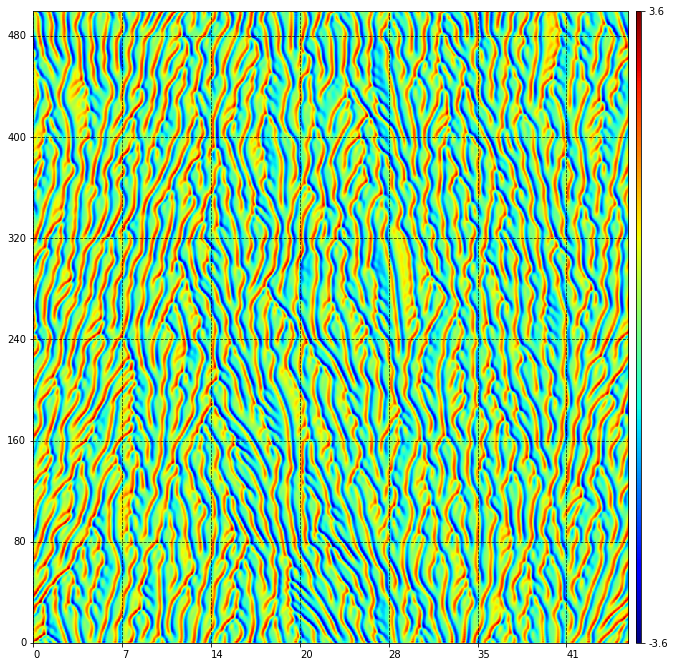

In [10]:
large_patch.plot()

<a id='families'></a>
# Insensitivity to choice of continuous family member.

First, use the covering algorithm with a collection of orbits generated by continuation in spatial domain size. 

In [11]:
large_patch = orb.read_h5('./data/large_patch.h5', '0/')

with h5py.File('./data/fpo_thresholds.h5', 'r') as file:
    thresholds = [file['defect'][...],
                  file['drifter'][...],
                  file['large_defect'][...],
                  file['wiggle'][...]]
defect_family = [x.transform(to='field') for x in orb.read_h5('./data/large_cover.h5', 'defect/')]

In [12]:
defect_family_cover = orb.OrbitCover(large_patch,
                         defect_family,
                         [thresholds[0]]*len(defect_family),
                         periodicity=(False, True),
                         replacement=False,
                         min_overlap = 1,
                        )

In [7]:
t0fam=time.time_ns()/10**9
defect_family_cover = orb.cover(defect_family_cover, verbose=True)
t1fam=time.time_ns()/10**9
print('\nCovering took {:.2f} seconds to complete'.format(t1fam-t0fam))

----------
Covering took 1053.41 seconds to complete


The covering algorithm is ran with 253 defect family members. 

Proportion of spacetime covered by the collection of orbit continuations is only 17%; even when using 253 family members.

In [8]:
defect_family_cover

OrbitCover({"base shape": [832, 832], "windows": 253})

In [9]:
tmpmap = defect_family_cover.map()
np.invert(tmpmap.mask.all(axis=0)).sum()/tmpmap.mask.all(axis=0).size

0.17686326969304733

In order to cover 99% of the spacetime area, we only need five of these members. In other words covering is not very sensitive to which continuous family member to use. This is good, considering there are an infinite number of family members by definition.

In [10]:
defect_family_minimal_cover = defect_family_cover.minimal_covering_set(cover_threshold=0.99)
print(f'Number of orbits in continuous family minimal cover: {len(defect_family_minimal_cover.windows)}')

Number of orbits in continuous family minimal cover: 5


In [30]:
# To show all scores in interact plot per orbit, pass masked=False to `trim` call.
family_trimmed = defect_family_cover.trim()
# Passing masked=False for map will take a good amount time, but it is possible. 
family_mapped = defect_family_cover.map()

In [31]:
((np.invert(defect_family_minimal_cover.map().mask.all(axis=0)).sum()/defect_family_minimal_cover.map().mask.all(axis=0).size) / 
(np.invert(family_mapped.mask.all(axis=0)).sum()/family_mapped.mask.all(axis=0).size))

0.9974842561811336

Interactive plot if actually running the notebook

In [5]:
# interactwrapper(defect_family_cover, trimmed_scores=family_trimmed, mapped_scores=family_mapped)

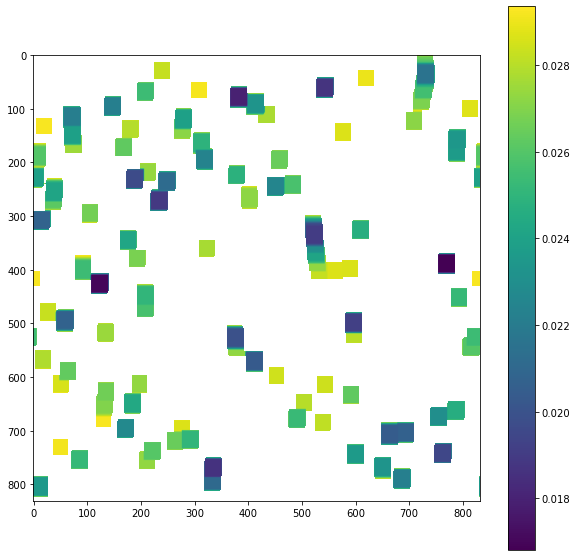

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(family_mapped.min(axis=0))
plt.colorbar()
plt.show()

### Dependence on group orbit members

The covering/shadowing algorithm is sensitive to discrete symmetry transformations because the relative changes in the field values is large.

In [15]:
windows = [x.transform(to='field') for x in orb.read_h5('./data/minimal_cover.h5')]
fundamental_windows = [list(x.group_orbit(fundamental_domain=True, rolls=(4, 4))) for x in windows[:1]]
window_thresholds = [len(f)*[t] for f, t in zip(fundamental_windows, thresholds)]
defect_group_orbit = fundamental_windows[0]
defect_group_orbit_thresholds = window_thresholds[0]

In [16]:
defect_group_orbit_cover = orb.OrbitCover(large_patch,
                     defect_group_orbit,
                     defect_group_orbit_thresholds,
                     periodicity=(False, True),
                     replacement=True,
                     min_overlap=1,
                    )

In [17]:
t0ad=time.time_ns()/10**9
defect_group_orbit_cover = orb.cover(defect_group_orbit_cover, verbose=True)
t1ad=time.time_ns()/10**9
print('\nCovering took {:.2f} seconds to complete'.format(t1ad-t0ad))

----------
Covering took 639.34 seconds to complete


Unlike the continuous family covering where only $\frac{5}{253} \approx 2\% $ orbits were needed to capture 99% of the spacetime covering, we need $\frac{116}{128}\approx 90\%$ of the group orbit members to capture 99% of the covering.

In [26]:
np.quantile(defect_group_orbit_cover.scores.data[defect_group_orbit_cover.scores.data!=np.inf], 0.001)

0.02654799477203787

In [41]:
# Typically do not do things this way, but for convenience. Note this is actually stricted than the typical threshold.
# This simply changes the masking. 

# aposteriori_thresholds = np.quantile(defect_group_orbit_cover.data[defect_group_orbit_cover.data!=np.inf], 0.001)
defect_group_orbit_cover.thresholds[...] = 0.02654799477203787
defect_group_orbit_cover.scores.mask = defect_group_orbit_cover.scores > 0.02654799477203787

In [44]:
defect_group_orbit_minimal_cover = defect_group_orbit_cover.minimal_covering_set(cover_threshold=0.99,verbose=False)
print(f'Number of orbits in group orbit minimal cover: {len(defect_group_orbit_minimal_cover.windows)}')

Number of orbits in group orbit minimal cover: 116


In [59]:
# To show all scores in interact plot per orbit, pass masked=False to `trim` call.
trimmed_go = defect_group_orbit_cover.trim()

In [45]:
# Passing masked=False for map will take a good amount time, but it is possible. 
mapped_go = defect_group_orbit_cover.map()

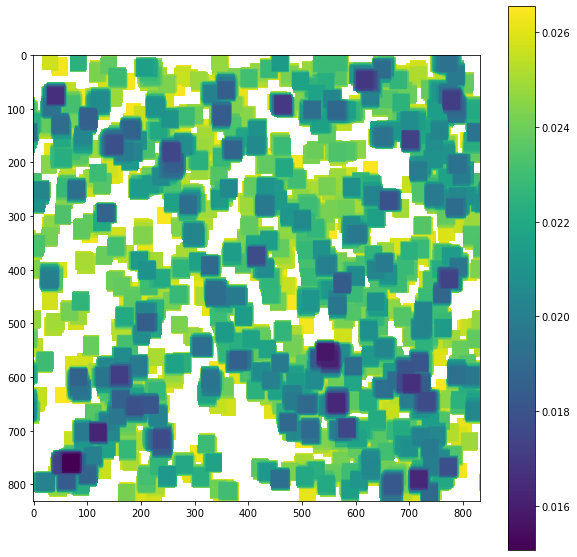

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(mapped_go.min(axis=0))
plt.colorbar()
plt.show()

In [6]:
# interactwrapper(defect_group_orbit_minimal_cover, trimmed_scores=trimmed_go, mapped_scores=mapped_go)

In [62]:
print('Percentage of spacetime covered by FPOs')
1 - (np.all(mapped_go.mask, axis=0).sum() / np.all(mapped_go.mask, axis=0).size)

Percentage of spacetime covered by FPOs


0.8219189164201184

82% is nice, but let's investigate further into which regions are not being captured and why.

# Accounting for spatial translation in shadowing. 

Covering with a rectangular fundamental domain shows that at the very least there is an algorithmic way detecting similar shapes. This missed the cases where the shapes are slanted due to local patches of spatial translation velocity. These patches are accompanied by locally non-zero Galilean velocity whose value depends on the spatial drift direction. Spatial drift in the $-x$ direction, i.e. "left slanting" wavelengths manifest as regions of spacetime which are more blue on average (mean value is non-zero and negative), and vice versa for spatial translations in the $+x$ direction. The next figure displays two such patches where the field is more red/blue on average.

In [50]:
spatial_drift_window_dimensions =  (((40, 320), (0, 8.5)), ((0, 160), (14, 28)))

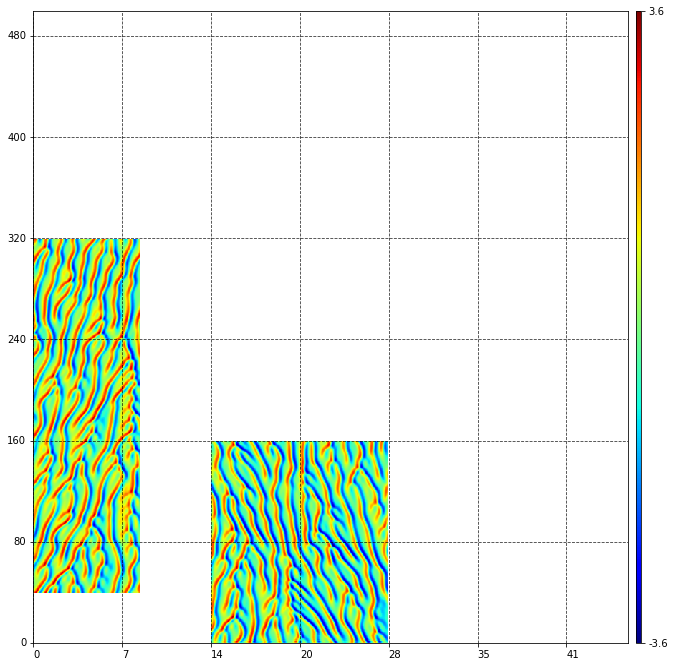

In [51]:
orb.clipping_mask(large_patch, spatial_drift_window_dimensions).plot()

Hopefully it is noticeable that the region defined on $t\in [40, 420], x\in[0, 8.5]$ is more "red" than blue, and vice versa for the other region. 

Now, it just so happens that if we reflect back on the previous covering ***these are exactly the regions where the covering was disproportionately poor***. To demonstrate this, let's look at the fraction of uncovered spacetime in these regions vs. the fraction of the total spacetime that they represent.

In [85]:
lpcopy = large_patch.copy()
lpcopy.state = mapped_go.mask.all(axis=0).astype(int)

fraction_of_total_uncovered_spacetime_in_clipped_regions = (orb.clipping_mask(lpcopy, spatial_drift_window_dimensions).state.sum()/
                                            lpcopy.state.astype(bool).sum())

fraction_of_total_spacetime_in_clipped_regions = (np.invert(orb.clipping_mask(lpcopy, spatial_drift_window_dimensions
                                                                       ).state.mask).sum()/
                                             np.invert(orb.clipping_mask(lpcopy,spatial_drift_window_dimensions
                                                                        ).state.mask).size)

In [86]:
fraction_of_total_spacetime_in_clipped_regions

0.19627750554733728

In [87]:
fraction_of_total_uncovered_spacetime_in_clipped_regions

0.4070835226166526

What does this demonstrate? Even though the clipped regions account for only 20% of the total spacetime, they constitute 40% of the spacetime missed by the defect group orbit shadowing. This provides some evidence that perhaps the spatially drifting regions are not covered by the "rectangular" representation of the defect; requiring us to expand the covering set beyond just the defect...OR, because this notebook is a demonstration of different techniques, we will manipulate the defect into a better form.

A demonstration of the poor covering performance in the clipped regions.

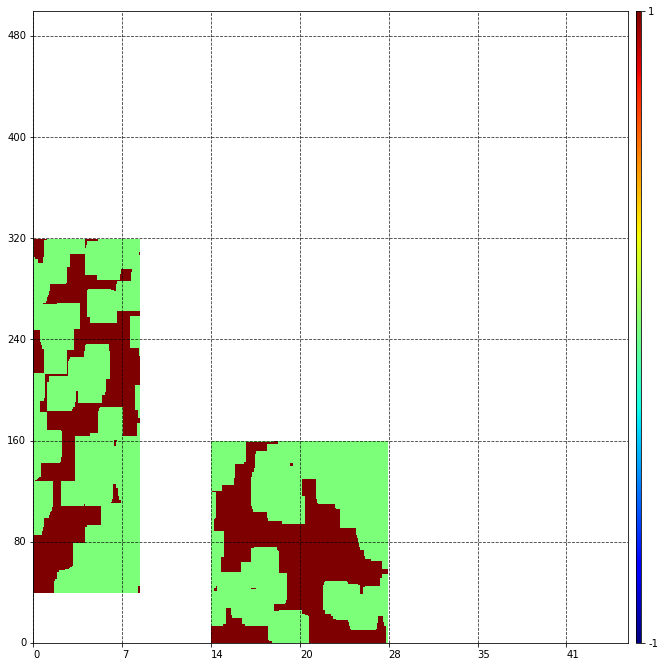

In [55]:
orb.clipping_mask(lpcopy, spatial_drift_window_dimensions).plot()

In [56]:
# if we only want to run covering over clipped region, provide this to orbi.cover calls as 'pivot_mask' keyword argument.
# from orbithunter.shadowing import _pad_orbit
# pivot_mask = np.invert(_pad_orbit(lpcopy, (32, 32), (False, True)).state)

# Non-rectangular fundamental domains.

Instead of simply include more FPOs into the calculation, the more complex alternative is to instead
map the defect FPO into a parallelipiped shape to mimic the spatial drift. Because the mean flow is accounted
for in the scoring metric, we do not need to add any constant values to the field. 

There are different ways of doing this but only one is the 'correct' way. The first is to map the tile into
a parallelogram but keep the orientation of field values the same. In otherwords, we would still have the same tiling, but the
fundamental domain/Brillouin zone of our tiling is now a parallelipiped. This mapped tile still represents shadowing by the previous orbit, albeit in a more exotic way. Therefore, it logically follows that this should *not* augment our previous results because in theory it's not adding any new information to the covering. 

In [13]:
def parallelipiped_tile_map(coordinates, **kwargs):
    """
    Map the tile into a parallelogram while maintaining the field's orientation.
    """
    x_indices = coordinates[1]
    t_indices = coordinates[0]
    shift = t_indices.shape[0]
    # use broadcasting by reshaping into n_components = size//shift
    shift_array_reshaped_for_broadcasting = np.arange(0, shift).reshape(-1, 1)
    new_x =  (x_indices - shift_array_reshaped_for_broadcasting).reshape(1, -1)
    if kwargs.get('window', False):
        new_x = np.mod(new_x, x_indices.shape[1])
    return np.concatenate(((t_indices).reshape(1, -1), new_x))

In [58]:
# where the threshold value 0.028315798375867566 came from. 
# parallelipiped_cover.thresholds[...] = np.quantile(
#     parallelipiped_cover.scores.data[parallelipiped_cover.scores.data!=np.inf], 0.001)

parallelipiped_threshs = 0.028315798375867566*np.ones(defect_group_orbit_cover.thresholds.shape)
parallelipiped_cover = orb.OrbitCover(large_patch,
                     [x.copy() for x in defect_group_orbit_cover.windows],
                     parallelipiped_threshs,
                     periodicity=(False, True),
                     replacement=True,
                     min_overlap=1,
                    coordinate_map=parallelipiped_tile_map                     
                    )

In [63]:
t0ad=time.time_ns()/10**9
parallelipiped_cover = orb.cover(parallelipiped_cover, verbose=True)
t1ad=time.time_ns()/10**9
print('\nCovering took {:.2f} seconds to complete'.format(t1ad-t0ad))

----------
Covering took 1108.38 seconds to complete


In [65]:
# parallelipiped_group_orbit_minimal_cover = parallelipiped_group_orbit_cover_result.minimal_covering_set()
# To show all scores in interact plot per orbit, pass masked=False to `trim` call.
trimmed_para = parallelipiped_cover.trim()
mapped_para = parallelipiped_cover.map()

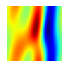

In [20]:
_ = plt.figure(figsize=(1,1))
_ = plt.imshow(defect_family_cover.windows[0].state,
          cmap='jet')
_ = plt.axis('off')

Changing tile to parallelipiped fundamental domain.

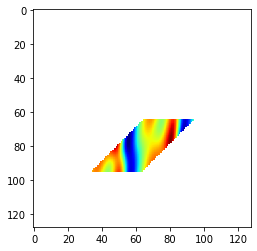

In [16]:
plt.imshow(coordinate_mapping_canvas(defect_family_cover.windows[0].state, parallelipiped_tile_map, sliced=False),
          cmap='jet')

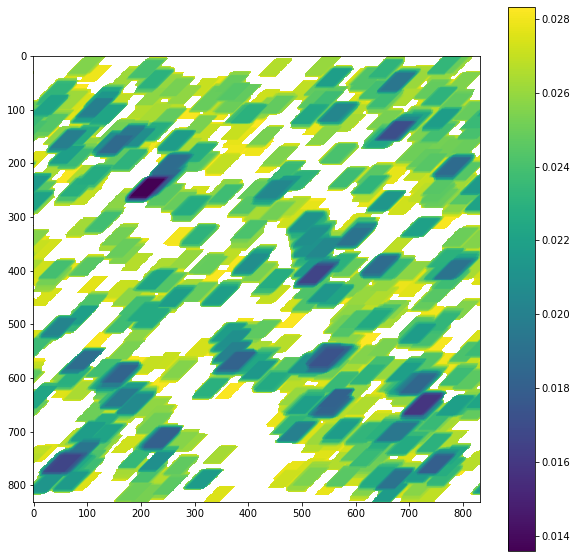

In [66]:
plt.figure(figsize=(10,10))
plt.imshow(mapped_para.min(axis=0))
plt.colorbar()
plt.show()

In [27]:
# interactwrapper(parallelipiped_cover, trimmed_scores=trimmed_para, mapped_scores=mapped_para)

# Mapping defect group orbit members into parallelipipeds

Instead of mapping the tile, we need to **actually** imbue the defect with a larger spatial drift. We do this by mapping the
field along with the tile into a parallelogram. Clearly due to symmetry we should have a left slanted and right slanted version.

In [21]:
def parallelipiped_field_map(coordinates, **kwargs):
    """
    Map the entire field into a parallelogram
    """
    x_indices = coordinates[1]
    t_indices = coordinates[0]
    if kwargs.get('window', False):
        return np.concatenate((t_indices.reshape(1,-1), x_indices.reshape(1, -1)))
    else:
        shift = t_indices.shape[0]
        # use broadcasting by reshaping into n_components = size//shift
    #     shift_array_reshaped_for_broadcasting = np.arange(shift//2, -shift//2, -1).reshape(-1, 1)
        shift_array_reshaped_for_broadcasting = np.arange(0, shift).reshape(-1, 1)
        new_x =  (x_indices - shift_array_reshaped_for_broadcasting).reshape(1, -1)
        return np.concatenate(((t_indices).reshape(1, -1), new_x))

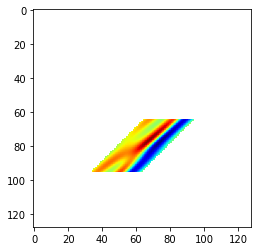

In [24]:
plt.imshow(coordinate_mapping_canvas(defect_family_cover.windows[0].state, parallelipiped_field_map, sliced=False),
          cmap='jet')

In [68]:
right_slant_parallelipiped_cover = orb.OrbitCover(large_patch,
                     [x.copy() for x in defect_group_orbit_cover.windows],
                     0.04032748374146777*np.ones(defect_group_orbit_cover.thresholds.shape),
                     periodicity=(False, True),
                     replacement=True,
                     min_overlap=1,
                    coordinate_map=parallelipiped_field_map                     
                    )

t0ad=time.time_ns()/10**9
right_slant_parallelipiped_cover = orb.cover(right_slant_parallelipiped_cover, verbose=True)
t1ad=time.time_ns()/10**9
print('\nCovering took {:.2f} seconds to complete'.format(t1ad-t0ad))

----------
Covering took 1072.09 seconds to complete


In [72]:
# where the threshold value  0.04032748374146777 came from

# another_parallelipiped_family_cover_result.thresholds[...] = np.quantile(
#     another_parallelipiped_family_cover_result.scores.data[another_parallelipiped_family_cover_result.scores.data!=np.inf],
#     0.001)

In [ ]:
# right_slant_parallelipiped_cover = right_slant_parallelipiped_cover.minimal_covering_set()

# To show all scores in interact plot per orbit, pass masked=False to `trim` call.
right_slant_trimmed = right_slant_parallelipiped_cover.trim()
right_slant_mapped = right_slant_parallelipiped_cover.map()

plt.figure(figsize=(10,10))
plt.imshow(right_slant_mapped.min(axis=0))
plt.colorbar()
plt.show()


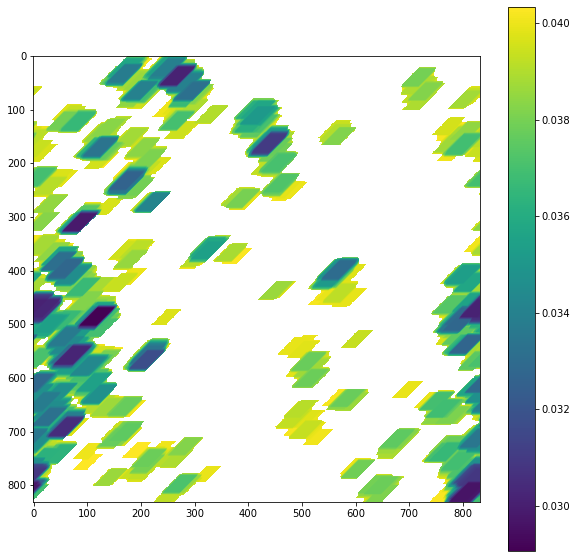

interactive(children=(IntSlider(value=0, description='orbit_index', max=127), Output()), _dom_classes=('widget…

In [148]:
interactwrapper(right_slant_parallelipiped_cover,
                trimmed_scores=right_slant_trimmed,
                mapped_scores=right_slant_mapped)

In [25]:
def parallelipiped_field_map_left_slant(coordinates, **kwargs):
    """
    Map the entire field into a parallelogram
    """
    x_indices = coordinates[1]
    t_indices = coordinates[0]
    if kwargs.get('window', False):
        return np.concatenate((t_indices.reshape(1,-1), x_indices.reshape(1, -1)))
    else:
        shift = t_indices.shape[0]
        # use broadcasting by reshaping into n_components = size//shift
    #     shift_array_reshaped_for_broadcasting = np.arange(shift//2, -shift//2, -1).reshape(-1, 1)
        shift_array_reshaped_for_broadcasting = np.arange(shift, 0, -1).reshape(-1, 1)
        new_x =  (x_indices - shift_array_reshaped_for_broadcasting).reshape(1, -1)
        return np.concatenate(((t_indices).reshape(1, -1), new_x))

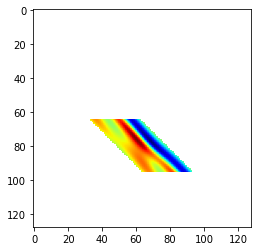

In [26]:
plt.imshow(coordinate_mapping_canvas(defect_family_cover.windows[0].state, parallelipiped_field_map_left_slant, sliced=False),
          cmap='jet')

In [75]:
left_slant_cover = orb.OrbitCover(large_patch,
                     [x.copy() for x in defect_group_orbit_cover.windows],
                     0.03999688597914493*np.ones(defect_group_orbit_cover.thresholds.shape),
                     periodicity=(False, True),
                     replacement=True,
                     min_overlap=1,
                    coordinate_map=parallelipiped_field_map_left_slant                     
                    )

t0ad=time.time_ns()/10**9
left_slant_cover = orb.cover(left_slant_cover, verbose=True)
t1ad=time.time_ns()/10**9
print('\nCovering took {:.2f} seconds to complete'.format(t1ad-t0ad))

----------
Covering took 1071.75 seconds to complete


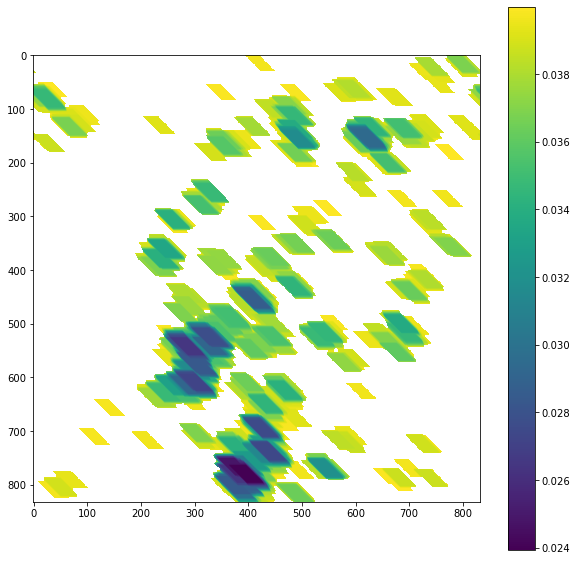

interactive(children=(IntSlider(value=0, description='orbit_index', max=127), Output()), _dom_classes=('widget…

In [76]:
# left_slant_cover = left_slant_cover_result.minimal_covering_set()

# To show all scores in interact plot per orbit, pass masked=False to `trim` call.
left_slant_trimmed = left_slant_cover.trim()
left_slant_mapped = left_slant_cover.map()

plt.figure(figsize=(10,10))
plt.imshow(left_slant_mapped.min(axis=0))
plt.colorbar()
plt.show()

interactwrapper(left_slant_cover,
                trimmed_scores=left_slant_trimmed,
                mapped_scores=left_slant_mapped)

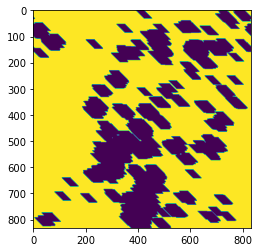

In [77]:
plt.imshow(left_slant_mapped.mask.all(axis=0))

Even though the thresholds were arbitrary, we can see that there is definitely not a uniform distribution of shadowing detections; this parallelopiped coordinate map seems to do a good job 

In [78]:
m00 = mapped_go.mask.all(axis=0) 
m01 = mapped_para.mask.all(axis=0) 
m10 = right_slant_mapped.mask.all(axis=0)
m11 = left_slant_mapped.mask.all(axis=0)

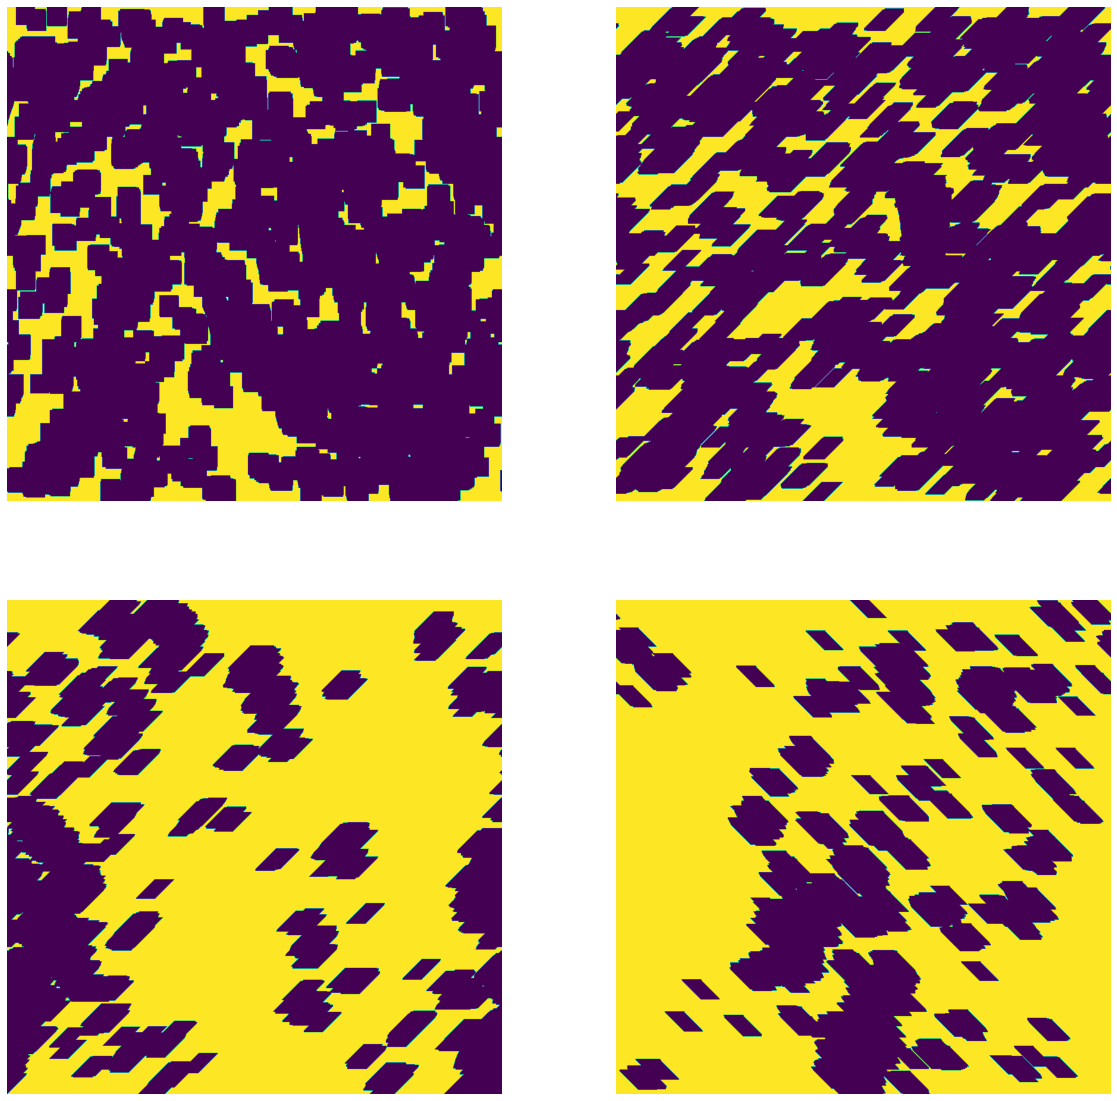

In [79]:
fig = plt.figure(figsize=(20,20)) 
gs = gridspec.GridSpec(2, 2)

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])    
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])

ax0.imshow(m00)
ax1.imshow(m01)
ax2.imshow(m10)
ax3.imshow(m11)
ax0.axis('off')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

plt.show()

And lastly, with our new additions, we can finally see how good of a job we have done.

In [93]:
spacetime_covering = np.all(np.concatenate([m00.reshape((1, *m00.shape)),
                                     m01.reshape((1, *m01.shape)),
                                     m10.reshape((1, *m10.shape)),
                                     m11.reshape((1, *m11.shape))], axis=0), axis=0)

(-0.5, 831.5, 831.5, -0.5)

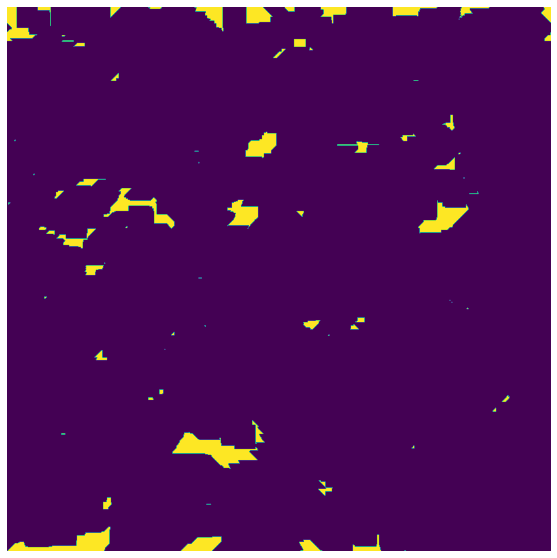

In [94]:
fig = plt.figure(figsize=(10,10)) 
plt.imshow(spacetime_covering)
plt.axis('off')

In [122]:
lpcopy = large_patch.copy()

In [123]:
lpcopy.state = np.ma.masked_array(lpcopy.state, mask=np.invert(spacetime_covering))

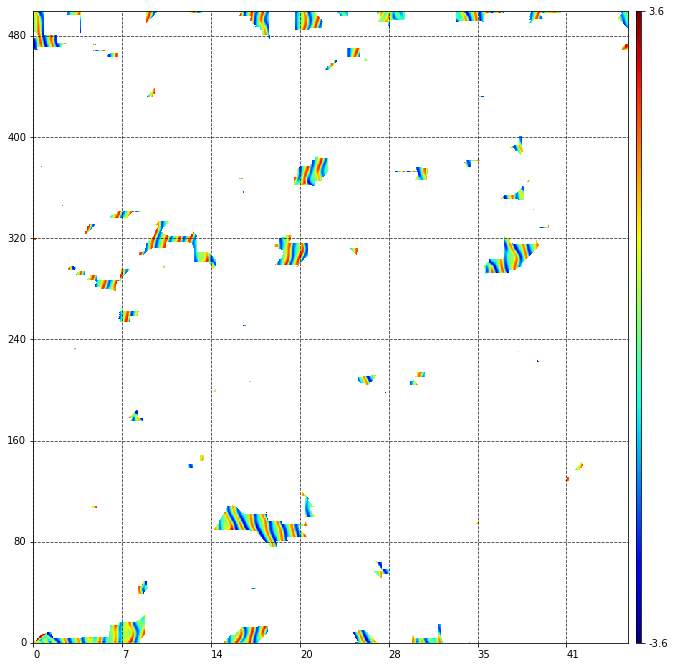

In [124]:
lpcopy.plot()

In [95]:
np.invert(spacetime_covering).sum() / spacetime_covering.size

0.9693119568232249

# Mean velocity in parallelipiped covers.

Do these parallelogram mapped tiles actually cover the local galilean shift velocity? Clearly each of the spacetime covers
should have non-zero mean flow. Additionally, the mean flow is constrained to zero globally; therefore these should approximately cancel out, if they are capturing both directions of the spatial drift. Likewise, we can compare these values with the mean flow in the spacetime region captured by the  


In [152]:
mapped_score_mask = mapped_go.mask.all(axis=0)
check_mean_velocity = large_patch.copy()
print(f'The mean flow in spacetime covered by the rectangular defect = '
      f'{np.ma.masked_array(check_mean_velocity.state, mask=mapped_score_mask).mean()}')

The mean flow in spacetime covered by the rectangular defect = -0.0019067650124241573


In [155]:
mapped_score_mask = right_slant_mapped.mask.all(axis=0)
check_mean_velocity = large_patch.copy()
print(f'The mean flow in spacetime covered by the right slanted defect = '
      f'{np.ma.masked_array(check_mean_velocity.state, mask=mapped_score_mask).mean()}')

The mean flow in spacetime covered by the right slanted defect = 0.1599415504539444


In [156]:
mapped_score_mask = left_slant_mapped.mask.all(axis=0)
check_mean_velocity = large_patch.copy()
print(f'The mean flow in spacetime covered by the left slanted defect = '
      f'{np.ma.masked_array(check_mean_velocity.state, mask=mapped_score_mask).mean()}')

The mean flow in spacetime covered by the left slanted defect = -0.15694805347021654


One might say that the coordinate mappings were specifically designed to capture this behavior and so the results are contrived; however, it is important to remember that the mean flow is always subtracted from the prospective shadowing region during the computation of the scores. Therefore, the fact that we capture non-zero mean flow in these regions is at least somewhat significant.

# Summary

With inclusion of these manipulated defect group orbit members, we can get the spacetime covering all the way up to $96.9\%$ with just a single family. The proper way of handling these parallelipiped regions is likely using the drifter relative equilibrium. 

Note that the coordinate mapping that we used assumed a single constant shift velocity for simplicity. If this type of analysis proves to be useful, then we should likely include a range of coordinate shifts magnitudes, from 0 to some maximum witnessed either in spacetime or in our collection of fundamental orbits (from previous investigations this will likely come from a relative equilibrium family).

Additionally, a comment on capture the shadowing at the border; this computation only included scoring pivots for which the window orbits were entirely in bounds. When paired with the aperiodic temporal boundary conditions, this means that partial orbit shadowings can occur at the boundary, which are less likely to be detected.   